<a href="https://colab.research.google.com/github/jmoranrun/HAR_Dist_ML/blob/main/Incremental_Shifting_Validation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### NoteBook for the Incremental Shifting Validation (ISV) Algorithm Experiments 
The ISV algorithm is used to evaluate the affect of training a model at the edge with edge users samples.  The assumption is that the model has already been trained a centrally using the data from multiple other users.  The algorithm illustrates the effect of different amounts of edge users data on model performance for that particualr edge user. The experiements use the HAR_Data Class to manipulate the HAR dataset.  This class allows for any arbitary assignment of data samples to the test and training dataset. Also, it allows for defined amount of the training data samples to be moved into the tranining dataset - this is needed for ISV.


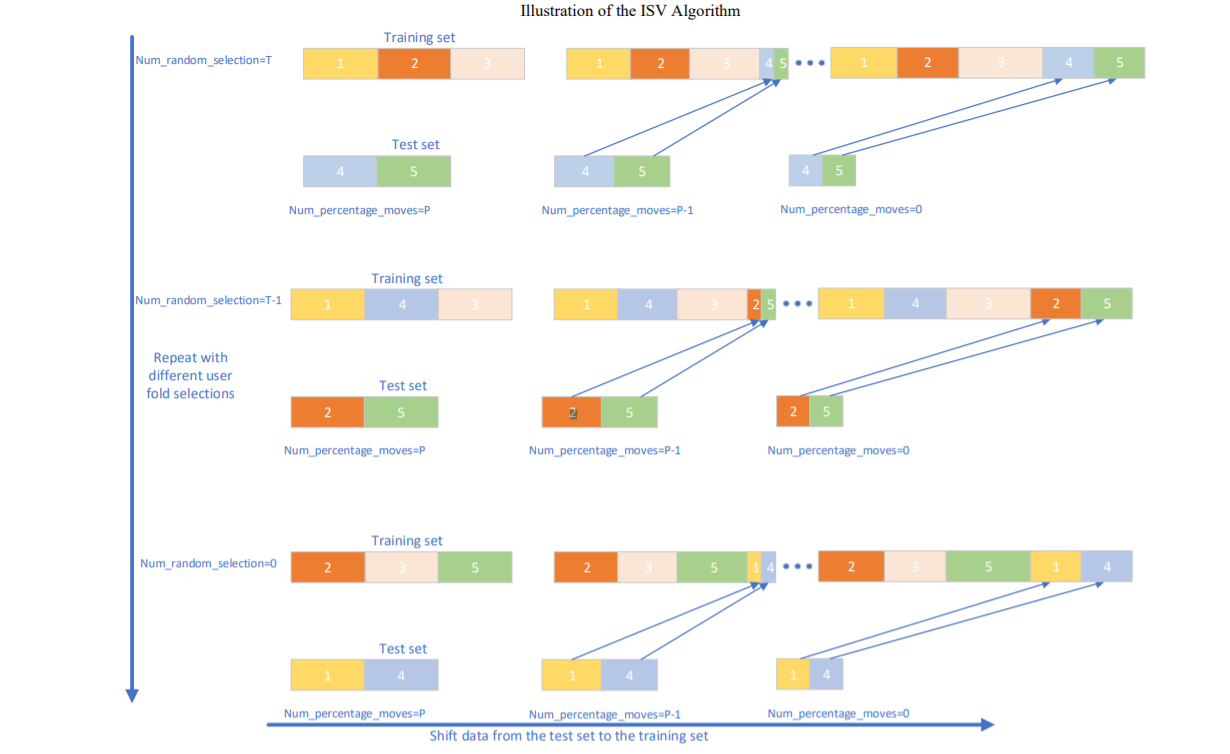

In [ ]:
 # load a single file as a numpy array
def load_file(filepath):
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
  return dataframe.values
 

## This files contains the training users mapping
sub_map_train = load_file('/content/drive/My Drive/Colab Notebooks/UCI_dataset/UCI HAR Dataset/train/subject_train.txt')
train_subjects = np.unique(sub_map_train)
print(train_subjects)
 
sub_map_test = load_file('/content/drive/My Drive/Colab Notebooks/UCI_dataset/UCI HAR Dataset/test/subject_test.txt')
test_subjects = np.unique(sub_map_test)
print(test_subjects)
 
 # These are the 9 featured provided by the UCI HAR Dataset
har_features = [
    "body_acc_x",
    "body_acc_y",
    "body_acc_z",
    "body_gyro_x",
    "body_gyro_y",
    "body_gyro_z",
    "total_acc_x",
    "total_acc_y",
    "total_acc_z"
]
 
num_of_timesamples = 128
num_of_feature = len(har_features)
num_of_samples = sub_map_train.shape[0] + sub_map_test.shape[0]
print("num_of_samples is",num_of_samples)

sub_map = np.concatenate((sub_map_test, sub_map_train), axis =0)
sub_map = sub_map.reshape(-1) 
print(sub_map)
unique, counts = np.unique(sub_map, return_counts=True)
print(dict(zip(unique, counts)))
 
################################################################################################################
# har_dataset is a 3-D np array of form: [num_of_samples, num_of_timesamples, num_of_feature]
#             Where num_of_samples is the total number of recorded activites 
#                   num_of_timesamples is the total number of timesammples in each recorded activity 
#                   num_of_feature is the total number of features recorded using the smartphones.
# This dataset removes the orginal test and training user mapping to samples and we want to 
# redefine this ourselves in various experiments
################################################################################################################
 
har_feature_cnt=0
har_dataset =  np.empty([num_of_samples, num_of_timesamples, num_of_feature])
for har_feature in har_features:
   har_feature_test  = load_file(f'/content/drive/My Drive/Colab Notebooks/UCI_dataset/UCI HAR Dataset/test/Inertial Signals/{har_feature}_test.txt')
   har_feature_train = load_file(f'/content/drive/My Drive/Colab Notebooks/UCI_dataset/UCI HAR Dataset/train/Inertial Signals/{har_feature}_train.txt')
   har_feature = np.concatenate((har_feature_test, har_feature_train), axis=0)
   har_dataset[:, :, har_feature_cnt] = har_feature 
   har_feature_cnt += 1

# Concatinate all of the datasamples together
x_concat = har_dataset
 
train_y =  load_file('/content/drive/My Drive/Colab Notebooks/UCI_dataset/UCI HAR Dataset/train/y_train.txt')
test_y =  load_file('/content/drive/My Drive/Colab Notebooks/UCI_dataset/UCI HAR Dataset/test/y_test.txt')
 
train_y = np.asarray(pd.get_dummies(train_y.reshape(-1, )))
test_y = np.asarray(pd.get_dummies(test_y.reshape(-1, )))

# Concatinate all of the datasamples classifications together
y_concat = np.concatenate((test_y,train_y),axis=0)
  

[ 1  3  5  6  7  8 11 14 15 16 17 19 21 22 23 25 26 27 28 29 30]
[ 2  4  9 10 12 13 18 20 24]
num_of_samples is 10299
[ 2  2  2 ... 30 30 30]
{1: 347, 2: 302, 3: 341, 4: 317, 5: 302, 6: 325, 7: 308, 8: 281, 9: 288, 10: 294, 11: 316, 12: 320, 13: 327, 14: 323, 15: 328, 16: 366, 17: 368, 18: 364, 19: 360, 20: 354, 21: 408, 22: 321, 23: 372, 24: 381, 25: 409, 26: 392, 27: 376, 28: 382, 29: 344, 30: 383}


In [ ]:
# set variables associated with the CNN
seg_len = 128
num_channels = 9
num_labels = 6
batch_size = 100
learning_rate = 0.001
num_epoches = 60
time_samples = 128
feature_sensors = 9
num_classes = 6
 
 
########################################
###### Define the CNN Model ############
########################################
 
opt = 'sgd'
model_har = Sequential()
model_har.add(Conv1D(filters=32,kernel_size=10,strides=1,activation='relu', input_shape=(time_samples, feature_sensors)))
model_har.add(MaxPooling1D(pool_size=4,strides=2, padding='same'))
model_har.add(Conv1D(filters=64,kernel_size=2,strides=1,activation='relu'))
model_har.add(Flatten())
model_har.add(Dense(50))
model_har.add(Activation('tanh'))
model_har.add(Dropout(0.6))
model_har.add(Dense(num_labels))
model_har.add(Activation('softmax'))


# Store the initail weights - used for experiments to ensure the same starting point
# This will allow for more better comparsions between optimization runs as the  
# randomness associated with different starting points is removed 
model_har.compile(loss='categorical_crossentropy',
              optimizer=opt, metrics=['accuracy'])
model_har.save_weights('/content/drive/My Drive/model_har_init.h5')
print(model_har.summary())

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 119, 32)           2912      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 60, 32)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 59, 64)            4160      
_________________________________________________________________
flatten_1 (Flatten)          (None, 3776)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                188850    
_________________________________________________________________
activation_1 (Activation)    (None, 50)                0         
______________________________________

#### Helper Functions 

In [ ]:

def report_accuracy(model_har, scores, percent_mix_run, mix_run):
  """
    Simple Function to Report accuracy of simuation
  """
  print('Test loss:', scores[0])
  print('Test accuracy:', scores[1])
  print("percent_mix_run is",percent_mix_run)
  print("mix_run is",mix_run)
  return  scores[1]


      # Two modes used to test the model
      # (1) Recompile -   here the initial weights are re-loaded each time
      #                   the experiement is run
      # (2) Incremental-  here the same weights that are updated after each 
      #                   training run are re-used. 

def select_compile_mode(compile_mode, percent_mix_run, model_har):
  """ 
  Function to selection compile mode
   Two modes used to test the model
       (1) Recompile -   here the initial weights are re-loaded each time
                         the experiement is run
       (2) Incremental-  here the same weights that are updated after each 
                         training run are re-used. 
  """
  tf.keras.backend.clear_session
  if(percent_mix_run != 0):
    if(compile_mode == "recompile"):
      model_har.load_weights('/content/drive/My Drive/model_har_init.h5')
    elif(compile_mode == "incremental_compile"):
      model_har.load_weights('/content/drive/My Drive/model_har_inc.h5')
  return model_har

In [ ]:
def run_mix(model_har, percent_mix_end = .5, percent_mix_num_samples = 10, num_of_mix_runs = 30, mix_users=False, compile_mode="incremental_compile", num_test_users=13):
  # Set variables
  percent_mix_values = np.linspace(0, percent_mix_end, percent_mix_num_samples)
  acc_result=np.zeros([percent_mix_num_samples, num_of_mix_runs])
  total_num_users=30

  for mix_run in range(num_of_mix_runs):
    percent_mix_run=0

    # Take a random selection of test/train users
    all_users = range(1, total_num_users)
    test_users = random.sample(all_users, 13)
    train_users=np.setdiff1d(all_users, test_users)

    model_har.load_weights('/content/drive/My Drive/model_har_init.h5')
    for percent_mix in  percent_mix_values:

      # Select compile mode. Incremental v's recompile
      model_har = select_compile_mode(compile_mode, percent_mix_run, model_har)  

      # Create an object of type HAR_Data, used to manipulate the data
      har_data = Har_Data.Har_Data(har_dataset, y_concat, sub_map, test_users, train_users)
      
      # Move Samples from the Test users to the Training users via the har_data object. percent_mix will
      # determine what percentage of the traning data samples will be moved into the trainind dataset
      har_dataset_user_test, har_submap_user_test, har_y_user_test, har_dataset_user_train, har_submap_user_train, har_y_user_train = \
      har_data.select_user_val(percent_mix)

      # Shuffle both the Test and Training datasets
      har_dataset_user_test, har_y_user_test = shuffle(har_dataset_user_test, har_y_user_test, random_state=0)
      har_dataset_user_train, har_y_user_train =  shuffle(har_dataset_user_train, har_y_user_train, random_state=0)

      # Decide whether to Mix the Test and Training Dataset together - typical state is not to.
      if(mix_users==True):
        test_size = (np.asarray(test_users).shape[0]/(np.asarray(train_users).shape[0]+np.asarray(test_users).shape[0]))-percent_mix*(np.asarray(test_users).shape[0]/(np.asarray(train_users).shape[0]+np.asarray(test_users).shape[0]))
        train_x, test_x, train_y, test_y = train_test_split(x_concat, y_concat, test_size = test_size, random_state = 0, shuffle =True)
      else:
        train_x, test_x, train_y, test_y = har_dataset_user_train, har_dataset_user_test, har_y_user_train, har_y_user_test
      
      # Now Fit (Train) the model with the Data Sets
      model_har.fit(train_x, train_y,
                batch_size=100,
                epochs=num_epoches,
                validation_split=0.2,
                shuffle=True, verbose=1)
      
      ## Save Weights after compile for an incremental compile on the next shift of data
      model_har.save_weights('/content/drive/My Drive/model_har_inc.h5')

      #Evaluate the model
      scores = model_har.evaluate(test_x, test_y, verbose=1)

      # Report accauracy of model
      acc = report_accuracy(model_har, scores, percent_mix_run, mix_run)     
      acc_result[percent_mix_run, mix_run] = acc
      percent_mix_run +=1

  return acc_result

####Functions for ploting results

In [ ]:
def plot_acc_each_run(acc_result):
## Plot the accuracy for each run.
  for col in range (acc_result.shape[1]):
    plt.plot(percent_mix_values,acc_result[:, col])
    plt.xlabel("Percent of user samples moved into training dataset")
    plt.ylabel("Accuracy of model")
    plt.title("Plot showing the effect of moving user samples \n from the users to traning dataset, run {}".format(col))
    plt.show()

In [ ]:

def plot_results(acc_result, percent_mix_end = .5, percent_mix_num_samples = 10, plot_gain=True):
  ## Plot the average accuracy for all run 
  ## and the average incremental accuracy for each run 
  percent_mix_values = np.linspace(0, percent_mix_end, percent_mix_num_samples)
  acc_result_av = np.mean(acc_result, axis=1)
  plt.plot(percent_mix_values,acc_result_av) 
  plt.xlabel("Percent of user samples moved into training dataset")
  plt.ylabel("Average accuracy of model")
  plt.title("Plot showing the effect of moving user samples\n from the users to traning dataset \n averaged over all runs")
  plt.show()

  ## For each run substract away the accuracy result from the first accuracy result (no mixing result)
  ## to obtain the incremental accuracy associated with each sample mix
  acc_result_offset=np.empty_like(acc_result)
  for col in range(acc_result.shape[1]):
    acc_result_offset[:, col] = acc_result[:, col] - acc_result[0, col]
  acc_result_offset_av = np.mean(acc_result_offset, axis=1)
  plt.plot(percent_mix_values,acc_result_offset_av) 
  plt.xlabel("Percent of user samples moved into training dataset")
  plt.ylabel("Average incremental accuracy of model")
  plt.title("Plot showing the effect of moving user samples\n from the users to traning dataset\n  incremental accuracy averaged over all runs")
  plt.show()
  if(plot_gain):
  ## Define a gain function - the incremental accuracy achieved as per percentage mixed
    gain_func = acc_result_offset_av[1:]/percent_mix_values[1:]
    plt.plot(percent_mix_values[1:], gain_func)
    plt.xlabel("Percent of user samples moved into training dataset")
    plt.ylabel("Accuracy Gain")
    plt.title("Plot showing the effect of moving user samples\n from the users to traning dataset \n averaged over all runs")
    plt.show()

  

In [ ]:
def plot_gain_func(acc_result_offset_av, percent_mix_values):
## Define a gain function - the incremental accuracy achieved as per percentage mixed
  gain_func = acc_result_offset_av[1:]/percent_mix_values[1:]
  plt.plot(gain_func)


#### Run the ISV algorithm to evaluate the effect of edge user compilation on accuary for a HAR dataset

In [ ]:
acc_result = run_mix(model_har=model_har, percent_mix_end = .5, percent_mix_num_samples = 10, num_of_mix_runs = 10, compile_mode="recompile") 
#acc_result = run_mix(model_har=model_har, percent_mix_end = .5, percent_mix_num_samples = 5, num_of_mix_runs = 10, compile_mode="incremental_compile") 

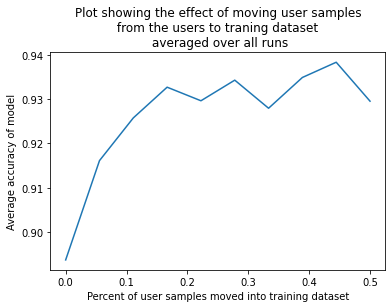

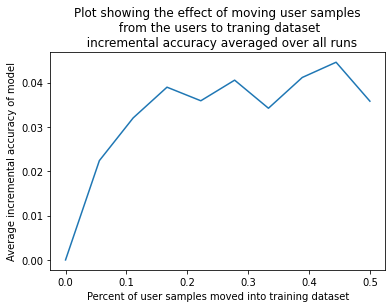

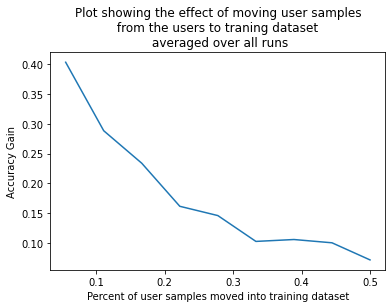

In [ ]:
plot_results(acc_result, percent_mix_end = .5, percent_mix_num_samples = 10)


The above plots clearly show an improvement in model accuracy when samples are shifted from the test dataset to the training dataset

Re-run the experiment with test and training data containing samples from all users to ensure that the gains seen in the previous experiment are due to the mixing of users, rather than the model simply beein trained with addtional samples.


In [ ]:
#acc_result = run_mix(model_har=model_har, percent_mix_end = .5, percent_mix_num_samples = 10, num_of_mix_runs = 20, mix_users=True) 
acc_result = run_mix(model_har=model_har, percent_mix_end = .5, percent_mix_num_samples = 5, num_of_mix_runs = 10, mix_users=True)

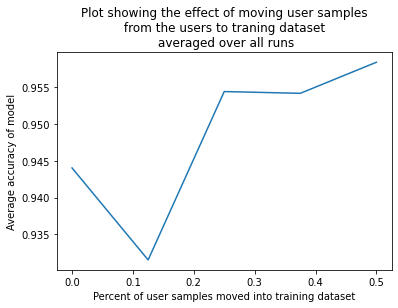

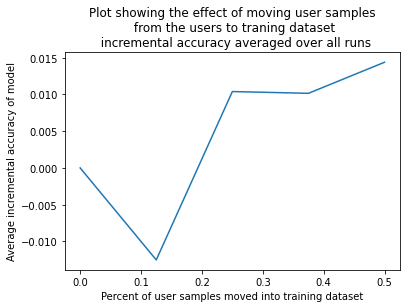

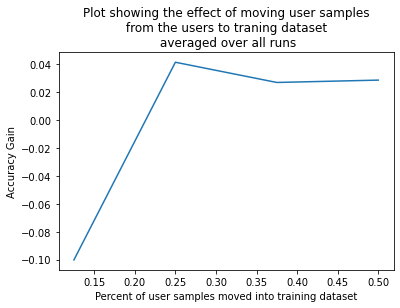

In [ ]:
plot_results(acc_result, percent_mix_end = .5, percent_mix_num_samples = 5)


As can be seen there is a much smaller gain in accuracy when the users samples are mixed together in both the traning and test datasets.  This shows that the gains seen in the first experiement are due to personalization of the model to a particular user.